In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter

%matplotlib inline

In [2]:
train = pd.read_csv('E:/Git-repository/data_mining/二手车价格预测组队学习/data/used_car_train_20200313.csv', sep=' ')
test = pd.read_csv('E:/Git-repository/data_mining/二手车价格预测组队学习/data/used_car_testA_20200313.csv', sep=' ')
print(train.shape)
print(test.shape)

(150000, 31)
(50000, 30)


In [3]:
train.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482


In [4]:
train.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3',
       'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14'],
      dtype='object')

In [5]:
test.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4',
       'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13',
       'v_14'],
      dtype='object')

In [6]:
def outliers_proc(data, col_name, scale=3):
    '''
    用于清洗异常值，默认用box_plot(scale=3)进行清洗
    ：param data：接受pandas数据格式
    ：param col_name：pandas列名
    ：param scale：尺度
    ：return：
    '''

    def box_plot_outliers(data_ser, box_scale):
        '''
        利用箱线图去除异常值
        ：param data_ser：接收pandas.Series数据格式
        ：param box_scale：箱线图尺度
        ：return：
        '''
        iqr = box_scale * (data_ser.quantile(0.75) - data_ser.quantile(0.25))
        val_low = data_ser.quantile(0.25) - iqr
        val_up = data_ser.quantile(0.75) + iqr
        rule_low = (data_ser < val_low)
        rule_up = (data_ser > val_up)
        return(rule_low, rule_up), (val_low, val_up)

    data_n = data.copy()
    data_series = data_n[col_name]
    rule, value = box_plot_outliers(data_series, box_scale=scale)
    index = np.arange(data_series.shape[0])[rule[0] | rule[1]]
    print('Delete number is: {}'.format(len(index)))
    data_n = data_n.drop(index)
    data_n.reset_index(drop=True, inplace=True)
    print('Now column number is: {}'.format(data_n.shape[0]))
    index_low = np.arange(data_series.shape[0])[rule[0]]
    outliers = data_series.iloc[index_low]
    print('Description of data less than the lower bound is:')
    print(pd.Series(outliers).describe())
    index_up = np.arange(data_series.shape[0])[rule[1]]
    outliers = data_series.iloc[index_up]
    print('Description of data larger than the upper bound is:')
    print(pd.Series(outliers).describe())

    fig, ax = plt.subplots(1, 2, figsize=(10, 7))
    sns.boxplot(y=data[col_name], data=data, palette='Set1', ax=ax[0])
    sns.boxplot(y=data_n[col_name], data=data_n, palette='Set1', ax=ax[1])
    return data_n

Delete number is: 963
Now column number is: 149037
Description of data less than the lower bound is:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: power, dtype: float64
Description of data larger than the upper bound is:
count      963.000000
mean       846.836968
std       1929.418081
min        376.000000
25%        400.000000
50%        436.000000
75%        514.000000
max      19312.000000
Name: power, dtype: float64


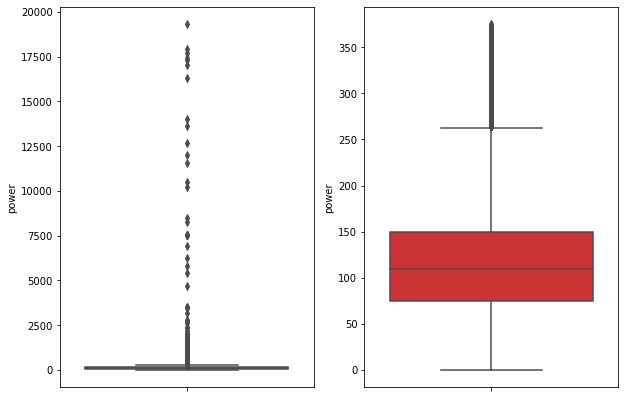

In [7]:
# 删掉一些异常数据，以power为例
# 注意test里的数据不能删
train = outliers_proc(train, 'power', scale=3)

In [8]:
#训练集和测试集放在一起，方便构造特征
train['train'] = 1
test['train'] = 0
data = pd.concat([train, test], ignore_index=True, sort=False)

In [9]:
# 使用时间：data['creatDate'] - data['regDate']反映汽车使用时间，一般来说价格与使用时间成反比
# 不过要注意，数据里有时间出错的格式，所以我们需要errors='coerce'
data['used_time'] = (pd.to_datetime(data['creatDate'], format='%Y%m%d', errors='coerce') - pd.to_datetime(data['regDate'], format='%Y%m%d', errors='coerce')).dt.days

In [10]:
# 看一下空数据
data['used_time'].isnull().sum()

15072

* 这里不建议删除空值，因为缺失数据占总样本量比例过大，15072/(150000+50000) = 7.5% 
* 可以先放着，因为如果有XGBoost之类的决策树，其本身就能处理缺失值，所以可以不用管

In [11]:
# 从邮编中提取城市信息，因为是德国的数据，所以参考德国的邮编，相当于加入了先验知识
data['city'] = data['regionCode'].apply(lambda x : str(x)[:-3])

In [12]:
# 计算某品牌的销售统计量，也可以计算其他特征的统计量
# 这里要以train的数据计算统计量
train_gb = train.groupby('brand')
all_info = {}
for kind, kind_data in train_gb:
    info = {}
    kind_data = kind_data[kind_data['price'] > 0]
    info['brand_amount'] = len(kind_data)
    info['brand_price_max'] = kind_data.price.max()
    info['brand_price_median'] = kind_data.price.median()
    info['brand_price_min'] = kind_data.price.min()
    info['brand_price_sum'] = kind_data.price.sum()
    info['brand_price_std'] = kind_data.price.std()
    info['brand_price_average'] = round(kind_data.price.sum() / (len(kind_data) + 1), 2)
    all_info[kind] = info
brand_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={'index':'brand'})
data = data.merge(brand_fe, how='left', on='brand')

In [13]:
# 对power进行分桶
bin = [i*10 for i in range(31)]
data['power_bin'] = pd.cut(data['power'], bin, labels=False)
data[['power_bin', 'power']].head()

,power_bin,power
0,5.0,60
1,NaN,0
2,16.0,163
3,19.0,193
4,6.0,68


In [14]:
# 利用好了，就可以删掉原始数据了
data = data.drop(['creatDate', 'regDate', 'regionCode'], axis=1)

In [15]:
print(data.shape)
data.columns

(199037, 39)


Index(['SaleID', 'name', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox',
       'power', 'kilometer', 'notRepairedDamage', 'seller', 'offerType',
       'price', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8',
       'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14', 'train', 'used_time',
       'city', 'brand_amount', 'brand_price_max', 'brand_price_median',
       'brand_price_min', 'brand_price_sum', 'brand_price_std',
       'brand_price_average', 'power_bin'],
      dtype='object')

In [16]:
# 目前的数据其实已经可以给树模型使用了，导出数据
data.to_csv('data_for_tree.csv', index=0)

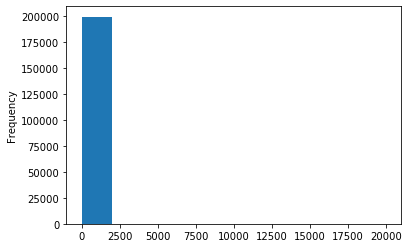

In [17]:
# 再构造一份特征给LR NN之类的模型用
# 因为不同模型对数据集的要求不同，因此分开构造
# 首先看下数据分布
data['power'].plot.hist()

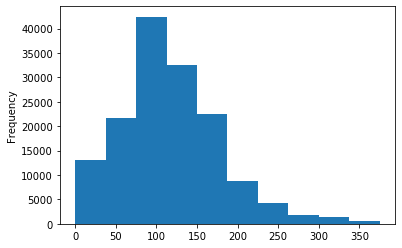

In [18]:
# 前面已经对train进行异常值处理了，但是现在还有这么奇怪的分布是因为test中的power异常值，所以其实前面train中的power异常值不删为好，可以用长尾截断分布来代替
train['power'].plot.hist()

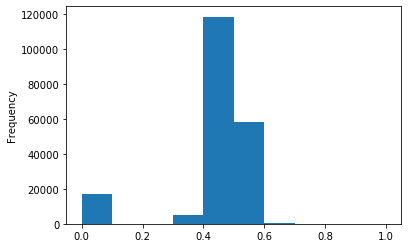

In [19]:
# 对其取log，再做归一化
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data['power'] = np.log(data['power'] + 1)
data['power'] = ((data['power'] - np.min(data['power'])) / (np.max(data['power']) - np.min(data['power'])))
data['power'].plot.hist()

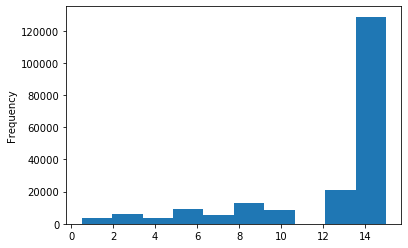

In [20]:
data['kilometer'].plot.hist()

In [21]:
# km的分布比较正常，应该是已经做过分桶了


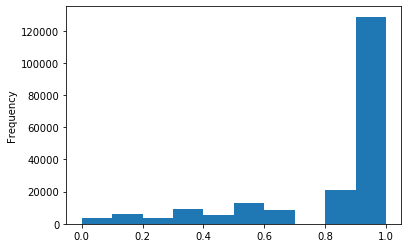

In [22]:
# 直接做归一化
data['kilometer'] = ((data['kilometer'] - np.min(data['kilometer'])) / (np.max(data['kilometer']) - np.min(data['kilometer'])))
data['kilometer'].plot.hist()

In [23]:
# 还有前面刚刚构造的统计量特征：'brand_amount', 'brand_price_average','brand_price_max','brand_price_median', 'brand_price_min','brand_price_std','brand_price_sum'，这里不再一一举例分析了，直接做变换。
def max_min(x): 
    return (x - np.min(x)) / (np.max(x) - np.min(x))

data['brand_amount'] = max_min(data['brand_amount'])
data['brand_price_average'] = max_min(data['brand_price_average'])
data['brand_price_max'] = max_min(data['brand_price_max'])
data['brand_price_median'] = max_min(data['brand_price_median'])
data['brand_price_min'] = max_min(data['brand_price_min'])
data['brand_price_std'] = max_min(data['brand_price_std'])
data['brand_price_sum'] = max_min(data['brand_price_sum'])

In [24]:
# 对类别进行 OneEncoder
data = pd.get_dummies(data, columns=['model', 'brand', 'bodyType', 'fuelType', 'gearbox', 'notRepairedDamage', 'power_bin'])

In [25]:
print(data.shape)
data.columns

(199037, 370)


Index(['SaleID', 'name', 'power', 'kilometer', 'seller', 'offerType', 'price',
       'v_0', 'v_1', 'v_2',
       ...
       'power_bin_20.0', 'power_bin_21.0', 'power_bin_22.0', 'power_bin_23.0',
       'power_bin_24.0', 'power_bin_25.0', 'power_bin_26.0', 'power_bin_27.0',
       'power_bin_28.0', 'power_bin_29.0'],
      dtype='object', length=370)

In [26]:
# 这份数据可以给LR用
data.to_csv('data_for_lr.csv', index=0)

In [27]:
# 相关性分析
print(data['power'].corr(data['price'], method='spearman'))
print(data['kilometer'].corr(data['price'], method='spearman'))
print(data['brand_amount'].corr(data['price'], method='spearman'))
print(data['brand_price_average'].corr(data['price'], method='spearman'))
print(data['brand_price_max'].corr(data['price'], method='spearman'))
print(data['brand_price_median'].corr(data['price'], method='spearman'))

0.5728285196051496
-0.4082569701616764
0.058156610025581514
0.3834909576057687
0.259066833880992
0.38691042393409447


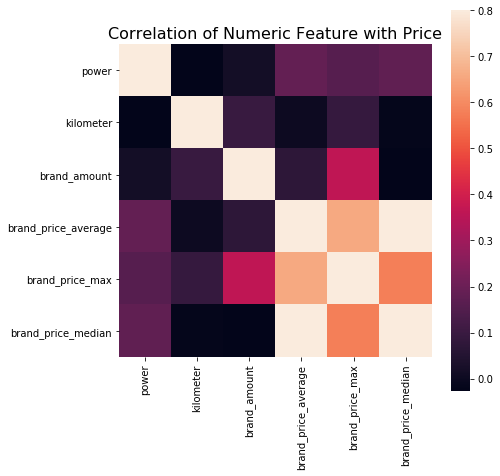

In [28]:
# 也可以直接看图
data_numeric = data[['power', 'kilometer', 'brand_amount', 'brand_price_average', 'brand_price_max', 'brand_price_median']]
correlation = data_numeric.corr()

f, ax = plt.subplots(figsize=(7,7))
plt.title('Correlation of Numeric Feature with Price', y=1, size=16)
sns.heatmap(correlation, square=True, vmax=0.8)

In [29]:
# k_feature 太大会很难跑，没服务器，所以提前 interrupt 了
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
sfs = SFS(LinearRegression(),
           k_features=10,
           forward=True,
           floating=False,
           scoring = 'r2',
           cv = 0)
x = data.drop(['price'], axis=1)
x = x.fillna(0)
y = data['price']
sfs.fit(x, y)
sfs.k_feature_names_ 

ModuleNotFoundError: No module named 'mlxtend'

In [30]:
import mlxtend

ModuleNotFoundError: No module named 'mlxtend'